In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
BUCKET = 1
IMAGE_SIZE = (256, 256)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [19]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_root_dir = os.path.join(working_dir, "landmarks/international/data_split")
data_dir = os.path.join(data_root_dir, str(BUCKET))
model_root_dir = os.path.join(working_dir, "models/XiZhe")

In [20]:
print('number of international labels:', len(os.listdir(data_dir)))

number of international labels: 200


In [24]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1488 images belonging to 200 classes.
Found 279 images belonging to 200 classes.


In [10]:
enet_model = EfficientNetB2(
    input_shape = IMAGE_SIZE + (3,),
    include_top = False,
    weights = 'imagenet'
)

31793152/31790344 [==============================] - 0s 0us/step


In [11]:
enet_model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 260, 260, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 260, 260, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [12]:
last_layer = enet_model.get_layer("top_activation")
last_output = last_layer.output

In [13]:
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation='softmax')(x)

model = Model(enet_model.input, x)

In [9]:
load_model_dir = os.path.join(model_root_dir, "efficientnet_b2_intl_classification_v2b")
model = tf.keras.models.load_model(load_model_dir)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 260, 260, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 260, 260, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [26]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = "adam",
    metrics = ['accuracy']
)

steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 23
Validation steps: 4


In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Epoch 1/30


InvalidArgumentError: ignored

In [72]:
save_model_dir = os.path.join(model_root_dir, "efficientnet_b2_intl_classification_v4b")
tf.keras.models.save_model(model, save_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS3244 Project/models/XiZhe/efficientnet_b2_intl_classification_v2b7/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS3244 Project/models/XiZhe/efficientnet_b2_intl_classification_v2b7/assets


Text(0.5, 1.0, 'Training and validation loss')

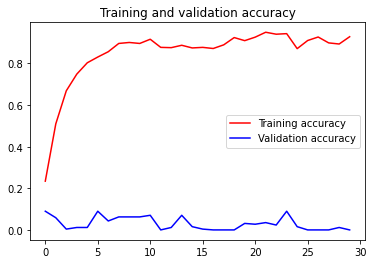

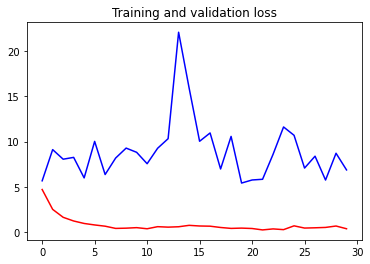

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')